# Import Model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection
import optuna
from optuna.integration import OptunaSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reduce File

In [2]:
pd.set_option("display.max_columns", 500)

In [3]:
df1 = pd.read_csv("fraudTest.csv", sep=',', header=0)

In [4]:
fraud_cases = df1[df1['is_fraud'] == 1]  
non_fraud_cases = df1[df1['is_fraud'] == 0]

In [5]:
num_fraud = len(fraud_cases)

In [6]:
max_non_fraud_samples = 10000 - num_fraud

In [7]:
if max_non_fraud_samples > 0:
    sampled_non_fraud = non_fraud_cases.sample(n=min(max_non_fraud_samples, len(non_fraud_cases)), random_state=42)
else:
    sampled_non_fraud = pd.DataFrame()

In [8]:
result = pd.concat([fraud_cases, sampled_non_fraud])

In [9]:
result = result.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
result.to_csv('reduced_data.csv', index=False)
print(f"Reduced dataset created with {len(result)} rows.")

Reduced dataset created with 10000 rows.


In [11]:
df = pd.read_csv("reduced_data.csv", sep=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             10000 non-null  int64  
 1   trans_date_trans_time  10000 non-null  object 
 2   cc_num                 10000 non-null  int64  
 3   merchant               10000 non-null  object 
 4   category               10000 non-null  object 
 5   amt                    10000 non-null  float64
 6   first                  10000 non-null  object 
 7   last                   10000 non-null  object 
 8   gender                 10000 non-null  object 
 9   street                 10000 non-null  object 
 10  city                   10000 non-null  object 
 11  state                  10000 non-null  object 
 12  zip                    10000 non-null  int64  
 13  lat                    10000 non-null  float64
 14  long                   10000 non-null  float64
 15  cit

# Data Preparation

In [12]:
# Transaction Time define to use
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['trans_year']=df['trans_date_trans_time'].dt.year

df["is_weekend"] = df["trans_date_trans_time"].dt.day_name().apply(lambda x : int((x == "Friday") | (x == "Sunday") | (x == "saturday")))
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"


df["day_period"] = df["trans_date_trans_time"].dt.hour.apply(day_period)
df["trans_month"] = df["trans_date_trans_time"].dt.month_name()

In [13]:
#Group the Age
df['dob']=pd.to_datetime(df['dob'])
df['dob_year']=df['dob'].dt.year
age = df.trans_year - df.dob_year
df["age"] = age
bins = [10, 18, 35, 60, 100]
labels = ["14-18", "18-35", "35-60", "60+"]
df["age_group"] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

In [14]:
#Group the State to Region
state_to_region = {
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast',
    'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast',
    'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'OH': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest', 'MI': 'Midwest',
    'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
    'DE': 'South', 'MD': 'South', 'DC': 'South', 'VA': 'South',
    'WV': 'South', 'NC': 'South', 'SC': 'South',
    'GA': 'South', 'FL': 'South', 'AL': 'South', 'MS': 'South',
    'TN': 'South', 'KY': 'South', 'AR': 'South', 'LA': 'South',
    'OK': 'South', 'TX': 'South', 'MT': 'Rocky Mountains', 'WY': 'Rocky Mountains',
    'CO': 'Rocky Mountains', 'NM': 'Rocky Mountains', 'ID': 'Rocky Mountains',
    'UT': 'Rocky Mountains', 'WA': 'Far West', 'OR': 'Far West',
    'CA': 'Far West', 'HI': 'Far West', 'AK': 'Far West'
}

df["Region"] = df.state.map(state_to_region)

In [15]:
# Group the Job
sector_bag = {
    "IT": ["engineer", "developer", "programmer", "software", "IT", "technician", "architect", "system", "network", 
           "administrator", "data scientist", "cybersecurity", "web developer", "analyst", "database", "devops"],
    
    "Education": ["teacher", "professor", "educator", "trainer", "lecturer", "scientist", "Orthoptist", "tutor", 
                  "principal", "instructor", "counselor", "academic", "researcher", "dean", "school", "headmaster"],
    
    "Healthcare": ["doctor", "nurse", "medical", "therapist", "pharmacist", "health", "surgeon", "dentist", "clinician", 
                   "physician", "optometrist", "radiologist", "paramedic", "midwife", "veterinarian", "psychiatrist"],
    
    "Finance": ["analyst", "accountant", "auditor", "banker", "financial", "investment", "controller", "broker", 
                "consultant", "treasurer", "loan officer", "trader", "actuary", "economist", "portfolio", "credit"],
    
    "Marketing": ["manager", "executive", "specialist", "consultant", "advertising", "public relations", "strategist", 
                  "director", "coordinator", "brand", "SEO", "content", "digital", "market research", "social media", 
                  "copywriter", "Public relations officer"],
    
    "Manufacturing": ["operator", "mechanic", "assembler", "fabricator", "engineer", "technician", "welder", 
                      "planner", "quality", "machinist", "production", "inspector", "supervisor", "foreman", 
                      "toolmaker", "CNC"],
    
    "Retail": ["cashier", "salesperson", "store", "associate", "manager", "clerk", "shopkeeper", "merchandiser", 
               "assistant", "retail", "customer service", "sales", "inventory", "buyer", "stocker", "checkout"],
    
    "Legal": ["lawyer", "attorney", "paralegal", "judge", "legal", "solicitor", "notary", "clerk", "litigator", 
              "advocate", "barrister", "counsel", "magistrate", "prosecutor", "defense", "compliance"],
    
    "Hospitality": ["chef", "waiter", "bartender", "host", "manager", "receptionist", "housekeeper", "concierge", 
                    "caterer", "cook", "hotel", "tour guide", "event planner", "sous chef", "sommelier", "valet"],
    
    "Construction": ["builder", "carpenter", "electrician", "plumber", "architect", "project manager", "site manager", 
                     "surveyor", "foreman", "bricklayer", "roofer", "civil engineer", "construction", "contractor", 
                     "inspector", "draftsman"]
}

def assign_sector(x):
    for key in sector_bag:
        for role in sector_bag[key]:
            if x.find(role) != -1:
                return key
    return "Other"

df['Job Sector'] = df['job'].apply(assign_sector)

In [16]:
df = df.drop(["Unnamed: 0","dob_year", "trans_date_trans_time", "merch_lat", "merch_long","first", "last", "street", "lat", "long", "dob", "trans_num", "unix_time", "zip", "age","state", "job", "city_pop"], axis=1)

In [17]:
df.head()

,cc_num,merchant,category,amt,gender,city,is_fraud,trans_year,is_weekend,day_period,trans_month,age_group,Region,Job Sector
0,6564459919350820,"fraud_Jenkins, Hauck and Friesen",gas_transport,75.79,M,Benton,0,2020,0,Night,December,60+,Midwest,Marketing
1,4451952084362894,fraud_Schuppe LLC,entertainment,81.57,M,Nazareth,0,2020,1,Night,July,35-60,South,IT
2,378006354724784,fraud_Lockman Ltd,grocery_pos,311.92,M,Etlan,1,2020,1,Night,November,35-60,South,Manufacturing
3,370818583810103,fraud_Johns Inc,entertainment,8.21,M,Rockwood,0,2020,1,Afternoon,July,35-60,Northeast,Healthcare
4,180067784565096,fraud_Frami Group,entertainment,2.32,F,North Prairie,0,2020,0,Afternoon,December,60+,Midwest,IT


In [18]:
df = pd.get_dummies(df, columns=[ "Job Sector", "cc_num", "merchant", "city"])

In [19]:
df["gender"] = df["gender"].replace({"F" : 1, "M" : 0})

/tmp/ipykernel_329/2508955403.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["gender"] = df["gender"].replace({"F" : 1, "M" : 0})


In [20]:
df

,category,amt,gender,is_fraud,trans_year,is_weekend,day_period,trans_month,age_group,Region,Job Sector_Construction,Job Sector_Education,Job Sector_Finance,Job Sector_Healthcare,Job Sector_IT,Job Sector_Legal,Job Sector_Manufacturing,Job Sector_Marketing,Job Sector_Other,Job Sector_Retail,cc_num_60416207185,cc_num_60422928733,cc_num_60423098130,cc_num_60427851591,cc_num_60487002085,cc_num_60490596305,cc_num_60495593109,cc_num_501802953619,cc_num_501831082224,cc_num_501882822387,cc_num_501899453424,cc_num_502012776709,cc_num_502038091380,cc_num_502049568400,cc_num_503848303379,cc_num_503851367360,cc_num_503874407318,cc_num_560881134780,cc_num_561942763351,cc_num_565399283797,cc_num_567868110212,cc_num_568279015842,cc_num_570273151375,cc_num_571314334723,cc_num_571365235126,cc_num_571465035400,cc_num_571844099986,cc_num_573283817795,cc_num_573860193545,cc_num_577588686219,cc_num_580954173374,cc_num_581293083266,cc_num_581508178315,cc_num_581686439828,cc_num_583699482621,cc_num_584673555952,cc_num_586100864972,cc_num_630412733309,cc_num_630423337322,cc_num_630424987505,cc_num_630425673344,cc_num_630441765090,cc_num_630451534402,cc_num_630469040731,cc_num_630484879808,cc_num_639023984367,cc_num_639030014711,cc_num_639046421587,cc_num_639077309909,cc_num_639095706599,cc_num_675909898057,cc_num_675945690716,cc_num_675961917837,cc_num_675990301623,cc_num_676102124465,cc_num_676118385837,cc_num_676148621961,cc_num_676173792455,cc_num_676195318214,cc_num_676234256292,cc_num_676245600876,cc_num_676248282243,cc_num_676275912597,cc_num_676281772837,cc_num_676292294938,cc_num_676298633337,cc_num_676308307625,cc_num_676309913934,cc_num_676314217768,cc_num_676326610042,cc_num_676369110710,cc_num_676372984911,cc_num_4006047418382,cc_num_4026222041577,cc_num_4066595222529,cc_num_4079773899158,cc_num_4103158249977,cc_num_4149635823017,cc_num_4158008602445,cc_num_4169388510116,cc_num_4186530744674,cc_num_4189814094741,cc_num_4195740185974,cc_num_4198470814557,cc_num_4220345354880,cc_num_4239436242473,cc_num_4247921790666,cc_num_4259996134423,cc_num_4260128500325,cc_num_4279161831637,cc_num_4294930380592,cc_num_4295296907373,cc_num_4306630852918,cc_num_4383521454815,cc_num_4393520897625,cc_num_4427805710168,cc_num_4440581794652,cc_num_4464457352619,cc_num_4471568287204,cc_num_4476840372112,cc_num_4481131401752,cc_num_4500002361389,cc_num_4505383113689,cc_num_4538566639857,cc_num_4561546772499,cc_num_4561892980175,cc_num_4562827002127,cc_num_4585132874641,cc_num_4586260469584,cc_num_4600155880464,cc_num_4601636330889,cc_num_4605902936394,cc_num_4613314721966,cc_num_4623560839669,cc_num_4640395708703,cc_num_4642894980163,cc_num_4658117080136,cc_num_4681699462969,cc_num_4683638447911,cc_num_4687263141103,cc_num_4745996322265,cc_num_4755696071492,cc_num_4760122961662,cc_num_4783226709001,cc_num_4788103653396,cc_num_4806443445305,cc_num_4807552641361,cc_num_4809701904914,cc_num_4862293128558,cc_num_4883407061576,cc_num_4900628639996,cc_num_4917226033950,cc_num_4957924165498,cc_num_4981132848794,cc_num_4988304376504,cc_num_4990494243023,cc_num_30011465039817,cc_num_30026790933302,cc_num_30029052116970,cc_num_30030380240193,cc_num_30033162392091,cc_num_30042378430132,cc_num_30044330818990,cc_num_30074693890476,cc_num_30082025922891,cc_num_30092964733035,cc_num_30103132002433,cc_num_30118423745458,cc_num_30131826429364,cc_num_30135235368675,cc_num_30143535920989,cc_num_30143713661454,cc_num_30150717898388,cc_num_30153452207526,cc_num_30175986190993,cc_num_30181367542315,cc_num_30197398657930,cc_num_30199621383748,cc_num_30230540139182,cc_num_30234966027947,cc_num_30235268718158,cc_num_30235438713303,cc_num_30238755902988,cc_num_30242921189660,cc_num_30248898834493,cc_num_30263540414123,cc_num_30266994494236,cc_num_30270432095985,cc_num_30273037698427,cc_num_30290551782700,cc_num_30328384440870,cc_num_30343344410970,cc_num_30344654314976,cc_num_30357372465631,cc_num_30360260465747,cc_num_30364087349027,cc_num_30371006069917,cc_num_30373802285317,cc_num_30

# Figures

### Fraud Cases

In [21]:
class_counts = df["is_fraud"].value_counts()
class_counts

is_fraud
0    7855
1    2145
Name: count, dtype: int64

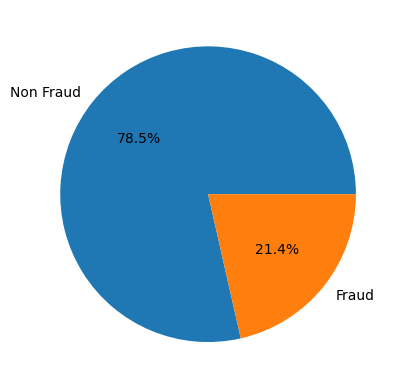

In [22]:
plt.pie(class_counts, labels=["Non Fraud", "Fraud"], autopct="%1.1f%%");

### Fraud Case by ages

In [23]:
age_fraud = df[df.is_fraud == 1].age_group.value_counts().reset_index()
age_fraud.columns = ["Age group", "Counts"]
age_not_fraud = df[df.is_fraud == 0].age_group.value_counts().reset_index()
age_not_fraud.columns = ["Age group", "Counts"]

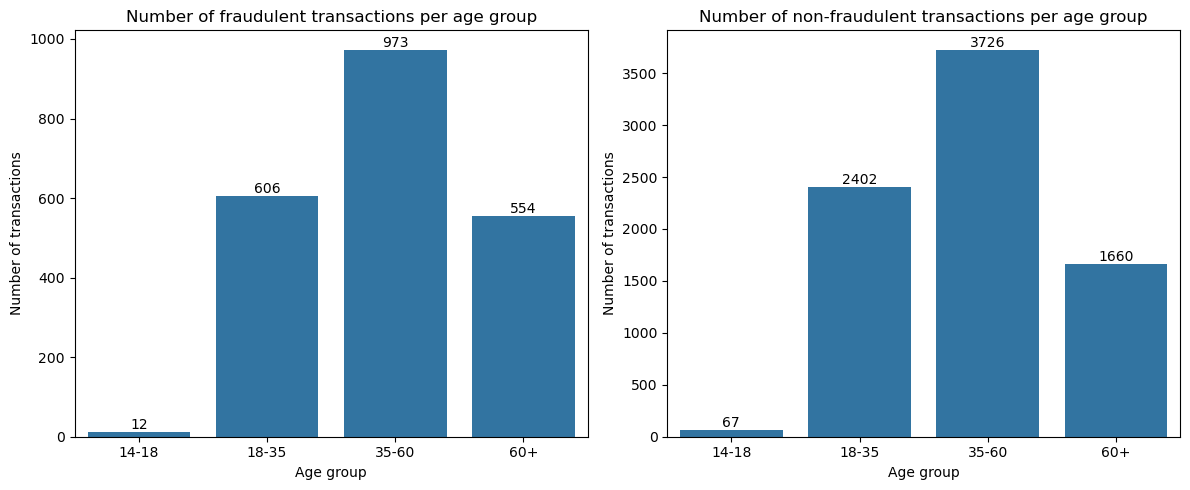

In [24]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Age group", y="Counts", data=age_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per age group")
axes[0].set_xlabel("Age group")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Age group", y="Counts", data=age_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per age group")
axes[1].set_xlabel("Age group")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

### Fraud Cases by categories

In [25]:
fraud = df[df.is_fraud == 1]
not_fraud = df[df.is_fraud == 0]

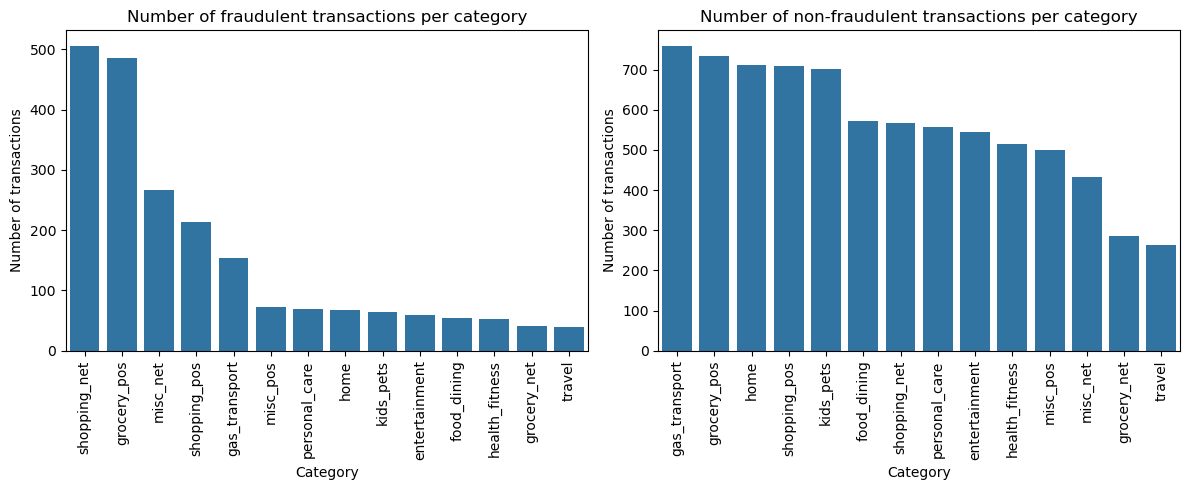

In [26]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Getting the counts of fraudulent and non-fraudulent activities per category
cat_fraud = fraud.category.value_counts().reset_index()
cat_fraud.columns = ["Category", "Counts"]
cat_not_fraud = not_fraud.category.value_counts().reset_index()
cat_not_fraud.columns = ["Category", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per category
sns.barplot(x="Category", y="Counts", data=cat_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Number of transactions")
axes[0].tick_params(axis="x", rotation=90)

sns.barplot(x="Category", y="Counts", data=cat_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Number of transactions")
axes[1].tick_params(axis="x", rotation=90)

plt.tight_layout()

### Fraud Cases by Regions

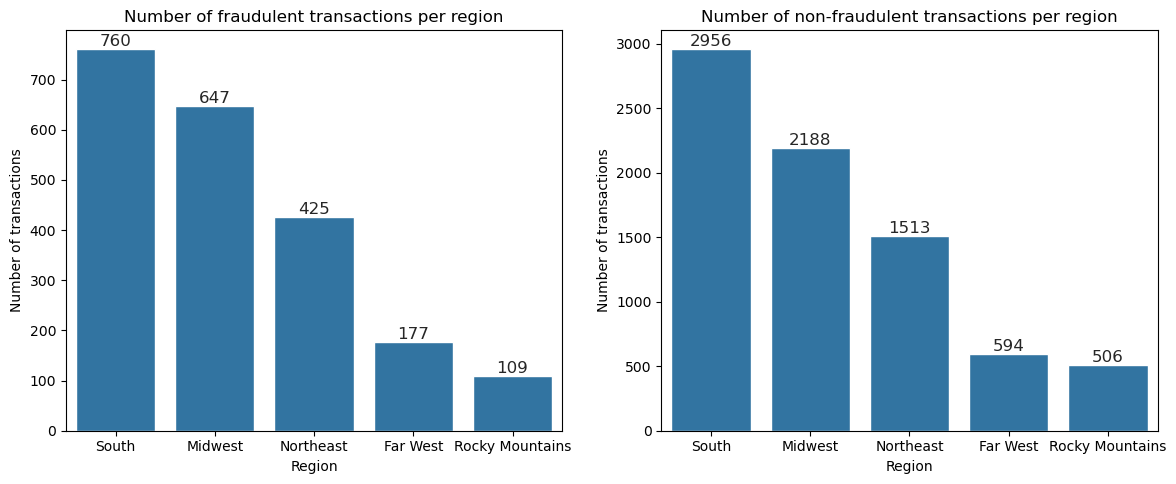

In [27]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Extracting fraudulent and non-fraudulent transactions by region
r_fraud = df[df.is_fraud == 1].Region.value_counts().reset_index()
r_fraud.columns = ["Region", "Counts"]
r_not_fraud = df[df.is_fraud == 0].Region.value_counts().reset_index()
r_not_fraud.columns = ["Region", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Region", y="Counts", data=r_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per region")
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Region", y="Counts", data=r_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per region")
axes[1].set_xlabel("Region")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

### Correlation (not done)

In [28]:
#plt.figure(figsize=(10, 8))
#correlation_matrix = df.corr()
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Heatmap')
#plt.show()

#cor_mat = df.corr()
#plt.imshow(cor_mat, cmap="coolwarm")
#plt.colorbar()

#variables = []
#for col in df.columns:
#    if df[col].dtypes in ["int64", "float64"]:
#        variables.append(col)

#plt.xticks(range(len(cor_mat)), variables, rotation=45, ha='right')
#plt.yticks(range(len(cor_mat)), variables)

#plt.show()

# Train Test Slit

In [29]:
df = pd.get_dummies(df, columns=["age_group", "category", "trans_year", "day_period", "trans_month", "Region" ])
df

,amt,gender,is_fraud,is_weekend,Job Sector_Construction,Job Sector_Education,Job Sector_Finance,Job Sector_Healthcare,Job Sector_IT,Job Sector_Legal,Job Sector_Manufacturing,Job Sector_Marketing,Job Sector_Other,Job Sector_Retail,cc_num_60416207185,cc_num_60422928733,cc_num_60423098130,cc_num_60427851591,cc_num_60487002085,cc_num_60490596305,cc_num_60495593109,cc_num_501802953619,cc_num_501831082224,cc_num_501882822387,cc_num_501899453424,cc_num_502012776709,cc_num_502038091380,cc_num_502049568400,cc_num_503848303379,cc_num_503851367360,cc_num_503874407318,cc_num_560881134780,cc_num_561942763351,cc_num_565399283797,cc_num_567868110212,cc_num_568279015842,cc_num_570273151375,cc_num_571314334723,cc_num_571365235126,cc_num_571465035400,cc_num_571844099986,cc_num_573283817795,cc_num_573860193545,cc_num_577588686219,cc_num_580954173374,cc_num_581293083266,cc_num_581508178315,cc_num_581686439828,cc_num_583699482621,cc_num_584673555952,cc_num_586100864972,cc_num_630412733309,cc_num_630423337322,cc_num_630424987505,cc_num_630425673344,cc_num_630441765090,cc_num_630451534402,cc_num_630469040731,cc_num_630484879808,cc_num_639023984367,cc_num_639030014711,cc_num_639046421587,cc_num_639077309909,cc_num_639095706599,cc_num_675909898057,cc_num_675945690716,cc_num_675961917837,cc_num_675990301623,cc_num_676102124465,cc_num_676118385837,cc_num_676148621961,cc_num_676173792455,cc_num_676195318214,cc_num_676234256292,cc_num_676245600876,cc_num_676248282243,cc_num_676275912597,cc_num_676281772837,cc_num_676292294938,cc_num_676298633337,cc_num_676308307625,cc_num_676309913934,cc_num_676314217768,cc_num_676326610042,cc_num_676369110710,cc_num_676372984911,cc_num_4006047418382,cc_num_4026222041577,cc_num_4066595222529,cc_num_4079773899158,cc_num_4103158249977,cc_num_4149635823017,cc_num_4158008602445,cc_num_4169388510116,cc_num_4186530744674,cc_num_4189814094741,cc_num_4195740185974,cc_num_4198470814557,cc_num_4220345354880,cc_num_4239436242473,cc_num_4247921790666,cc_num_4259996134423,cc_num_4260128500325,cc_num_4279161831637,cc_num_4294930380592,cc_num_4295296907373,cc_num_4306630852918,cc_num_4383521454815,cc_num_4393520897625,cc_num_4427805710168,cc_num_4440581794652,cc_num_4464457352619,cc_num_4471568287204,cc_num_4476840372112,cc_num_4481131401752,cc_num_4500002361389,cc_num_4505383113689,cc_num_4538566639857,cc_num_4561546772499,cc_num_4561892980175,cc_num_4562827002127,cc_num_4585132874641,cc_num_4586260469584,cc_num_4600155880464,cc_num_4601636330889,cc_num_4605902936394,cc_num_4613314721966,cc_num_4623560839669,cc_num_4640395708703,cc_num_4642894980163,cc_num_4658117080136,cc_num_4681699462969,cc_num_4683638447911,cc_num_4687263141103,cc_num_4745996322265,cc_num_4755696071492,cc_num_4760122961662,cc_num_4783226709001,cc_num_4788103653396,cc_num_4806443445305,cc_num_4807552641361,cc_num_4809701904914,cc_num_4862293128558,cc_num_4883407061576,cc_num_4900628639996,cc_num_4917226033950,cc_num_4957924165498,cc_num_4981132848794,cc_num_4988304376504,cc_num_4990494243023,cc_num_30011465039817,cc_num_30026790933302,cc_num_30029052116970,cc_num_30030380240193,cc_num_30033162392091,cc_num_30042378430132,cc_num_30044330818990,cc_num_30074693890476,cc_num_30082025922891,cc_num_30092964733035,cc_num_30103132002433,cc_num_30118423745458,cc_num_30131826429364,cc_num_30135235368675,cc_num_30143535920989,cc_num_30143713661454,cc_num_30150717898388,cc_num_30153452207526,cc_num_30175986190993,cc_num_30181367542315,cc_num_30197398657930,cc_num_30199621383748,cc_num_30230540139182,cc_num_30234966027947,cc_num_30235268718158,cc_num_30235438713303,cc_num_30238755902988,cc_num_30242921189660,cc_num_30248898834493,cc_num_30263540414123,cc_num_30266994494236,cc_num_30270432095985,cc_num_30273037698427,cc_num_30290551782700,cc_num_30328384440870,cc_num_30343344410970,cc_num_30344654314976,cc_num_30357372465631,cc_num_30360260465747,cc_num_30364087349027,cc_num_30371006069917,cc_num_30373802285317,cc_num_30376238035123,cc_num_30404291151692,cc_num_30407675418785,cc_

In [30]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [32]:
X_train.shape

(7000, 2489)

In [33]:
df

,amt,gender,is_fraud,is_weekend,Job Sector_Construction,Job Sector_Education,Job Sector_Finance,Job Sector_Healthcare,Job Sector_IT,Job Sector_Legal,Job Sector_Manufacturing,Job Sector_Marketing,Job Sector_Other,Job Sector_Retail,cc_num_60416207185,cc_num_60422928733,cc_num_60423098130,cc_num_60427851591,cc_num_60487002085,cc_num_60490596305,cc_num_60495593109,cc_num_501802953619,cc_num_501831082224,cc_num_501882822387,cc_num_501899453424,cc_num_502012776709,cc_num_502038091380,cc_num_502049568400,cc_num_503848303379,cc_num_503851367360,cc_num_503874407318,cc_num_560881134780,cc_num_561942763351,cc_num_565399283797,cc_num_567868110212,cc_num_568279015842,cc_num_570273151375,cc_num_571314334723,cc_num_571365235126,cc_num_571465035400,cc_num_571844099986,cc_num_573283817795,cc_num_573860193545,cc_num_577588686219,cc_num_580954173374,cc_num_581293083266,cc_num_581508178315,cc_num_581686439828,cc_num_583699482621,cc_num_584673555952,cc_num_586100864972,cc_num_630412733309,cc_num_630423337322,cc_num_630424987505,cc_num_630425673344,cc_num_630441765090,cc_num_630451534402,cc_num_630469040731,cc_num_630484879808,cc_num_639023984367,cc_num_639030014711,cc_num_639046421587,cc_num_639077309909,cc_num_639095706599,cc_num_675909898057,cc_num_675945690716,cc_num_675961917837,cc_num_675990301623,cc_num_676102124465,cc_num_676118385837,cc_num_676148621961,cc_num_676173792455,cc_num_676195318214,cc_num_676234256292,cc_num_676245600876,cc_num_676248282243,cc_num_676275912597,cc_num_676281772837,cc_num_676292294938,cc_num_676298633337,cc_num_676308307625,cc_num_676309913934,cc_num_676314217768,cc_num_676326610042,cc_num_676369110710,cc_num_676372984911,cc_num_4006047418382,cc_num_4026222041577,cc_num_4066595222529,cc_num_4079773899158,cc_num_4103158249977,cc_num_4149635823017,cc_num_4158008602445,cc_num_4169388510116,cc_num_4186530744674,cc_num_4189814094741,cc_num_4195740185974,cc_num_4198470814557,cc_num_4220345354880,cc_num_4239436242473,cc_num_4247921790666,cc_num_4259996134423,cc_num_4260128500325,cc_num_4279161831637,cc_num_4294930380592,cc_num_4295296907373,cc_num_4306630852918,cc_num_4383521454815,cc_num_4393520897625,cc_num_4427805710168,cc_num_4440581794652,cc_num_4464457352619,cc_num_4471568287204,cc_num_4476840372112,cc_num_4481131401752,cc_num_4500002361389,cc_num_4505383113689,cc_num_4538566639857,cc_num_4561546772499,cc_num_4561892980175,cc_num_4562827002127,cc_num_4585132874641,cc_num_4586260469584,cc_num_4600155880464,cc_num_4601636330889,cc_num_4605902936394,cc_num_4613314721966,cc_num_4623560839669,cc_num_4640395708703,cc_num_4642894980163,cc_num_4658117080136,cc_num_4681699462969,cc_num_4683638447911,cc_num_4687263141103,cc_num_4745996322265,cc_num_4755696071492,cc_num_4760122961662,cc_num_4783226709001,cc_num_4788103653396,cc_num_4806443445305,cc_num_4807552641361,cc_num_4809701904914,cc_num_4862293128558,cc_num_4883407061576,cc_num_4900628639996,cc_num_4917226033950,cc_num_4957924165498,cc_num_4981132848794,cc_num_4988304376504,cc_num_4990494243023,cc_num_30011465039817,cc_num_30026790933302,cc_num_30029052116970,cc_num_30030380240193,cc_num_30033162392091,cc_num_30042378430132,cc_num_30044330818990,cc_num_30074693890476,cc_num_30082025922891,cc_num_30092964733035,cc_num_30103132002433,cc_num_30118423745458,cc_num_30131826429364,cc_num_30135235368675,cc_num_30143535920989,cc_num_30143713661454,cc_num_30150717898388,cc_num_30153452207526,cc_num_30175986190993,cc_num_30181367542315,cc_num_30197398657930,cc_num_30199621383748,cc_num_30230540139182,cc_num_30234966027947,cc_num_30235268718158,cc_num_30235438713303,cc_num_30238755902988,cc_num_30242921189660,cc_num_30248898834493,cc_num_30263540414123,cc_num_30266994494236,cc_num_30270432095985,cc_num_30273037698427,cc_num_30290551782700,cc_num_30328384440870,cc_num_30343344410970,cc_num_30344654314976,cc_num_30357372465631,cc_num_30360260465747,cc_num_30364087349027,cc_num_30371006069917,cc_num_30373802285317,cc_num_30376238035123,cc_num_30404291151692,cc_num_30407675418785,cc_

# Decision Tree

In [34]:
#Decision Tree
model_tree = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)
model_tree.fit(X_train, y_train)

y_pred_tree = model_tree.predict(X_test)
y_pred_tree_prob = model_tree.predict_proba(X_test)[:, 1] 
y_pred_tree_prob

array([0.96513944, 0.01395089, 0.01395089, ..., 0.98901099, 0.96513944,
       0.01395089])

In [35]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
accuracy_tree

0.946

In [36]:
precision_tree = precision_score(y_test, y_pred_tree, pos_label=1)
recall_tree = recall_score(y_test, y_pred_tree, pos_label=1)
f1_tree = f1_score(y_test, y_pred_tree, pos_label=1)

In [37]:
column_names = X_train.columns

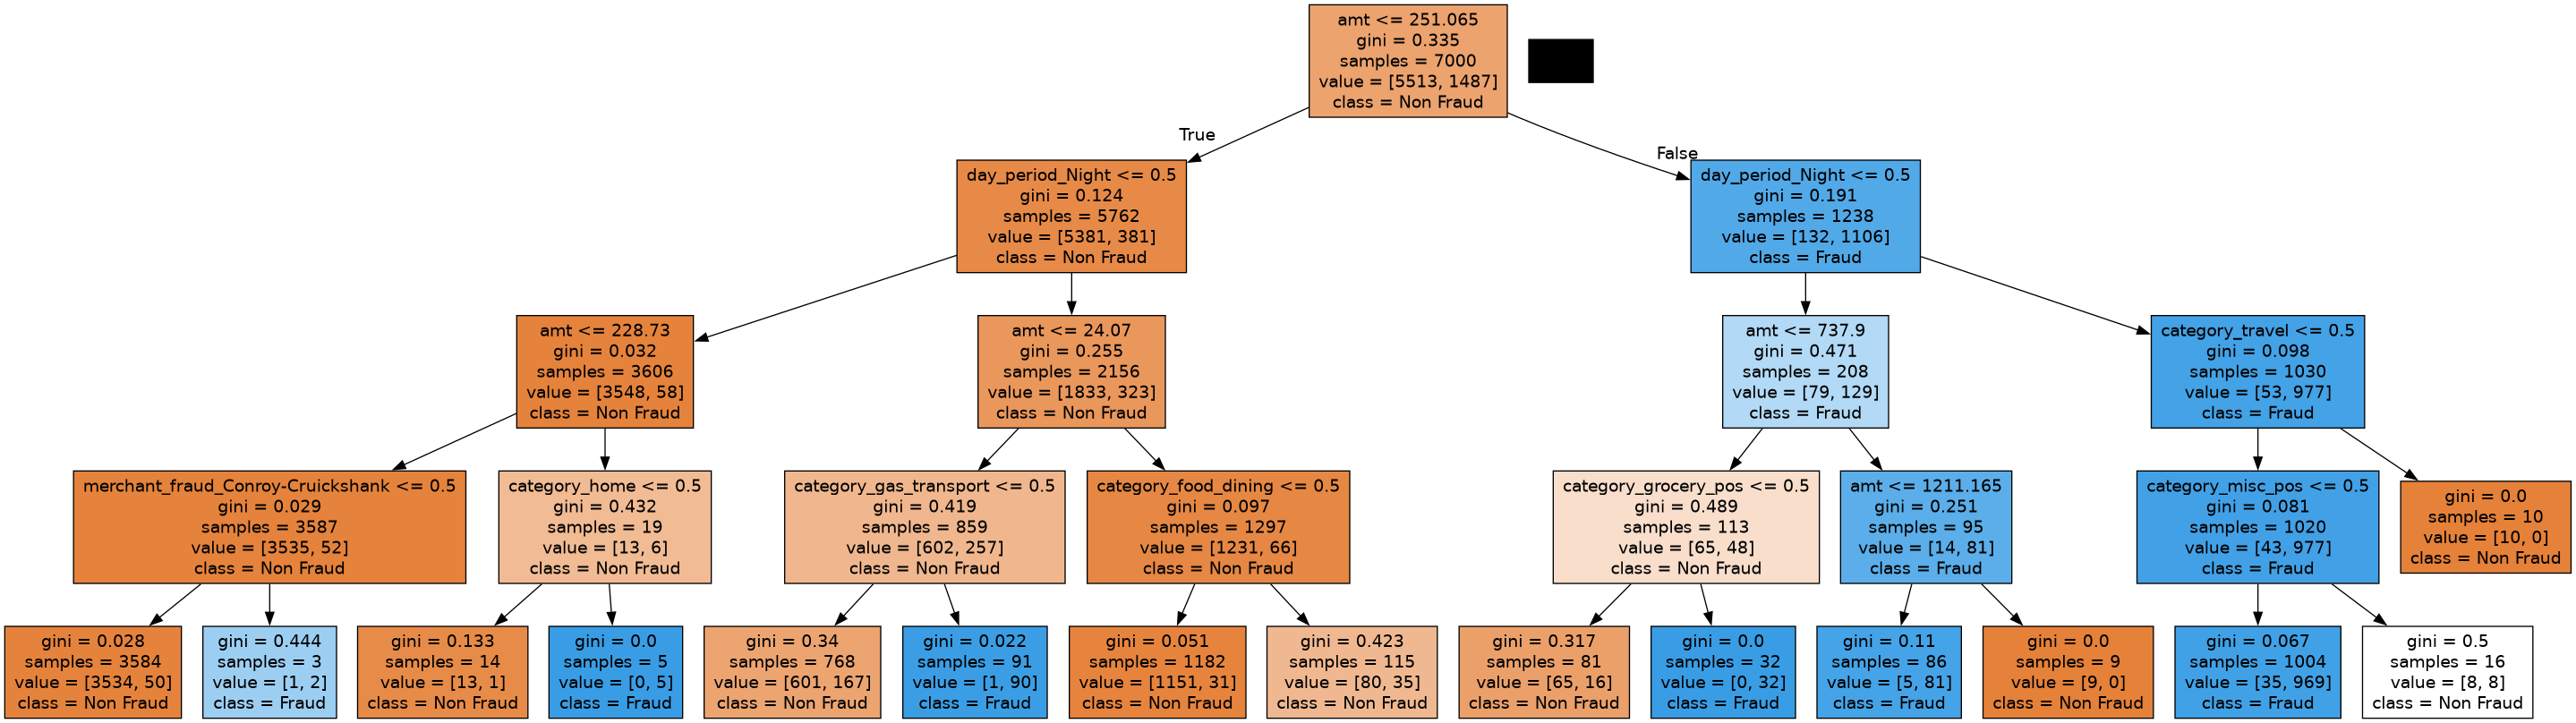

In [38]:
# Graph
dot_data = tree.export_graphviz(model_tree, out_file=None, 
                                feature_names=column_names, 
                                class_names=["Non Fraud", "Fraud"], filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

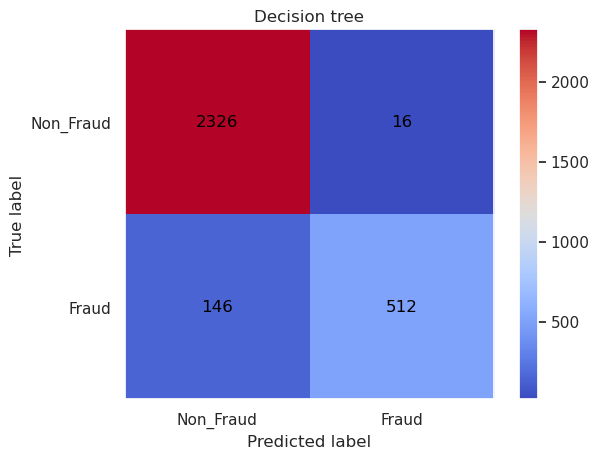

In [39]:
rf_cm = confusion_matrix(y_test, y_pred_tree)
rf_mat = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Non_Fraud", "Fraud"])
rf_mat.plot(cmap="coolwarm")
for text in rf_mat.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.title("Decision tree")
plt.show()

# Logistic Regression

In [40]:
model_logreg = LogisticRegression(max_iter=20000, random_state=1234)
model_logreg.fit(X_train, y_train)

LogisticRegression(max_iter=20000, random_state=1234)

In [41]:
y_pred_logreg = model_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test,y_pred_logreg)
accuracy_logreg

0.9276666666666666

In [42]:
precision_logreg = precision_score(y_test, y_pred_logreg, pos_label=1)
recall_logreg = recall_score(y_test, y_pred_logreg, pos_label=1)
f1_logreg = f1_score(y_test, y_pred_logreg, pos_label=1)

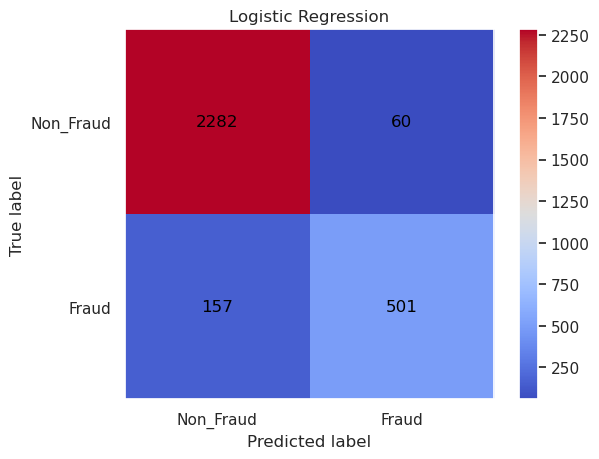

In [43]:
rf_cm = confusion_matrix(y_test, y_pred_logreg)
rf_mat = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Non_Fraud", "Fraud"])
rf_mat.plot(cmap="coolwarm")
for text in rf_mat.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.title("Logistic Regression")
plt.show()

# Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf = RandomForestClassifier(class_weight="balanced", random_state=1234)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1234)

In [46]:
y_predrf = rf.predict(X_test)

In [47]:
accuracy_rf = accuracy_score(y_test, y_predrf)
accuracy_rf

0.9566666666666667

In [48]:
precision_rf = precision_score(y_test, y_predrf, pos_label=1)
recall_rf = recall_score(y_test, y_predrf, pos_label=1)
f1_rf = f1_score(y_test, y_predrf, pos_label=1)

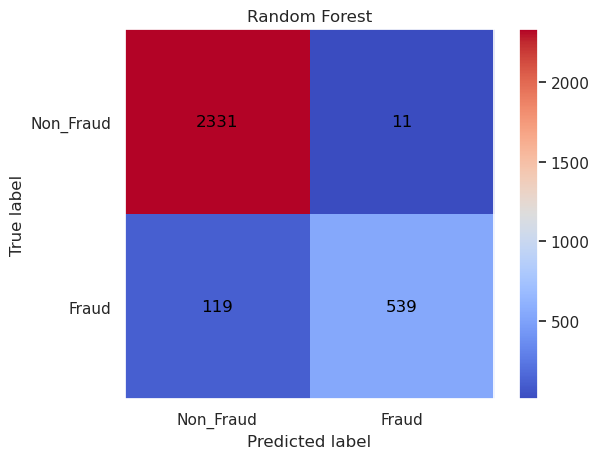

In [49]:
rf_cm = confusion_matrix(y_test, y_predrf)
rf_mat = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Non_Fraud", "Fraud"])
rf_mat.plot(cmap="coolwarm")
for text in rf_mat.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.title("Random Forest")
plt.show()

# XGBoost

In [50]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [51]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)
y_pred_xgboost = xgb_classifier.predict(X_test)

/opt/software/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [52]:
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
accuracy_xgboost

0.973

In [53]:
precision_xgboost = precision_score(y_test, y_pred_xgboost, pos_label=1)
recall_xgboost = recall_score(y_test, y_pred_xgboost, pos_label=1)
f1_xgboost = f1_score(y_test, y_pred_xgboost, pos_label=1)

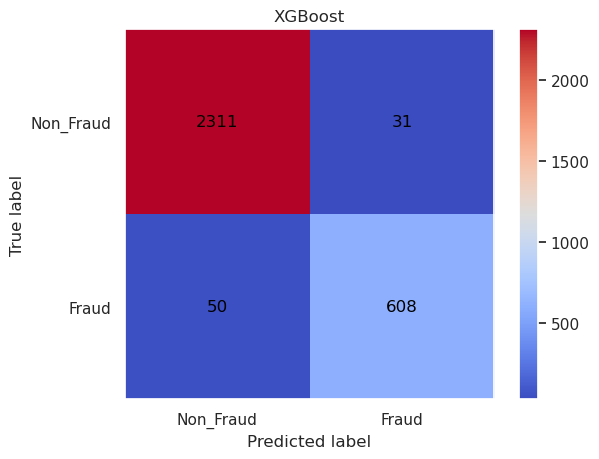

In [54]:
rf_cm = confusion_matrix(y_test, y_pred_xgboost)
rf_mat = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Non_Fraud", "Fraud"])
rf_mat.plot(cmap="coolwarm")
for text in rf_mat.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.title("XGBoost")
plt.show()

# ROC and AUC

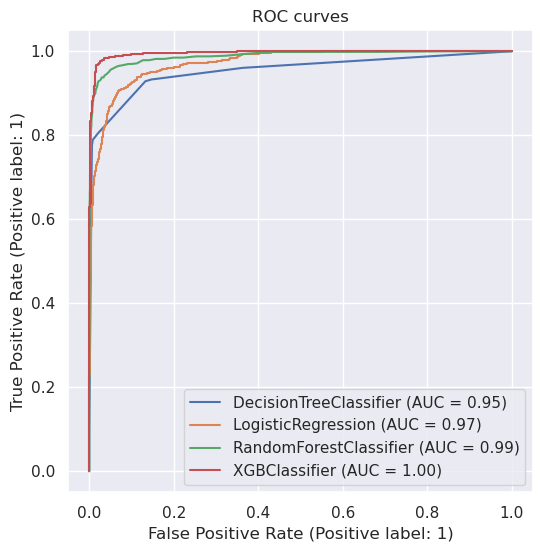

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title("ROC curves")
RocCurveDisplay.from_estimator(model_tree, X_test, y_test,ax=ax)
RocCurveDisplay.from_estimator(model_logreg, X_test, y_test,ax=ax)
RocCurveDisplay.from_estimator(rf, X_test, y_test,ax=ax)
RocCurveDisplay.from_estimator(xgb_classifier, X_test, y_test,ax=ax)

# Summary

In [56]:
data = {
    'Model': ['Random Forest', 'XGBoost', 'Decision Tree', 'Logistic Regression'],
    'Accuracy': [accuracy_rf, accuracy_xgboost, accuracy_tree, accuracy_logreg]}

In [57]:
data = {
    'Model': ['Random Forest', 'XGBoost', 'Decision Tree', 'Logistic Regression'],
    'Accuracy': [accuracy_rf, accuracy_xgboost, accuracy_tree, accuracy_logreg],
    'Precision (Fraud)': [precision_rf, precision_xgboost, precision_tree, precision_logreg],
    'Recall (Fraud)': [recall_rf, recall_xgboost, recall_tree, recall_logreg],
    'F1-Score (Fraud)': [f1_rf, f1_xgboost, f1_tree, f1_logreg]
}

In [58]:
model_df = pd.DataFrame(data)
model_df

,Model,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,Random Forest,0.956667,0.980000,0.819149,0.892384
1,XGBoost,0.973000,0.951487,0.924012,0.937548
2,Decision Tree,0.946000,0.969697,0.778116,0.863406
3,Logistic Regression,0.927667,0.893048,0.761398,0.821985
